In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

sys.path.append('/Users/alexkelber/Documents/DataScience')
warnings.filterwarnings('ignore')



In [2]:
train, test = pd.read_csv('input/train.csv'), pd.read_csv('input/test.csv')
for col in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name', 'Cabin']:
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(test[col].mode()[0])
for col in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    train[col] = train[col].fillna(train[col].mean())
    test[col] = test[col].fillna(test[col].mean())
for bool_col in ['Transported', 'CryoSleep', 'VIP']:
    train[bool_col] = train[bool_col].replace({True: 1, False: 0})
    test[bool_col] = test[bool_col].replace({True: 1, False: 0})
planet_ordinal_map = {
    'Earth': 0,
    'Mars': 1,
    'Europa': 2,
    '55 Cancri e': 0,
    'PSO J318.5-22': 1,
    'TRAPPIST-1e': 2
    
    
}
def parse_info(row):
    if row['Cabin'] and isinstance(row['Cabin'], str):
        cabin = row['Cabin'].split('/')
        row['CabinDeck'] = ord(cabin[0]) - 65
        row['CabinPort'] = 1 if cabin[2] == 'P' else 0
    row['PassengerGroup'] = row['PassengerId'][:4]
    row['Surname'] = row['Name'].split(' ')[-1]
    row['HomePlanet'] = planet_ordinal_map[row['HomePlanet']]
    row['Destination'] = planet_ordinal_map[row['Destination']]
    return row
train = train.apply(parse_info, axis=1).drop('Cabin', axis=1)
test = train.apply(parse_info, axis=1).drop('Cabin', axis=1)
train['GroupSize'] = train.groupby(['PassengerGroup'])['PassengerId'].transform('count')
train['SurnameCount'] = train.groupby(['Surname'])['PassengerId'].transform('count')
test['GroupSize'] = test.groupby(['PassengerGroup'])['PassengerId'].transform('count')
test['SurnameCount'] = test.groupby(['Surname'])['PassengerId'].transform('count')
for spending_col in ['FoodCourt', 'Spa', 'RoomService', 'ShoppingMall', 'VRDeck']:
    train[spending_col].replace(to_replace=0, value=np.nan, inplace=True)
    train[spending_col] = pd.qcut(train[spending_col], 10, labels=False).fillna(-1)
    test[spending_col].replace(to_replace=0, value=np.nan, inplace=True)
    test[spending_col] = pd.qcut(test[spending_col], 10, labels=False).fillna(-1)

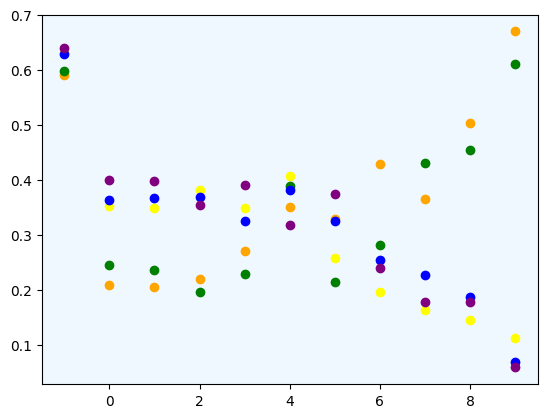

In [3]:
df = train.copy()
cols = [('FoodCourt', 'orange'), 
        ('RoomService', 'yellow'),
        ('ShoppingMall', 'green'),
        ('VRDeck', 'blue'),
        ('Spa', 'purple')]
plt.rcParams['axes.facecolor'] = '#f0f8ff'
for col, color in cols:
        col_sum = df.groupby([col])['Transported'].transform('sum') 
        col_count = df.groupby([col])['Transported'].transform('count') 
        df['Rate'] = col_sum / col_count
        rate = df.groupby([col]).agg(TransportedRate=('Rate', np.mean), Total=('Rate', np.size))
        plt.scatter(rate.index, rate['TransportedRate'], c=color);

In [4]:
train2 = train.drop(['PassengerId', 'Name', 'Surname', 'PassengerGroup'], axis=1)
test2 = train.drop(['PassengerId', 'Name', 'Surname', 'PassengerGroup'], axis=1)
# quardratic_columns = ['HomePlanet', 'Destination', 'Age', 'FoodCourt', 'ShoppingMall',
#                       'Spa', 'VRDeck', 'CabinDeck']
# for col in quardratic_columns:
#     train2[col + '_2'] = train2[col] ** 2

In [8]:
from custom_ml_utils.compare_models import ModelComparer

X, y = train2.drop(['Transported'], axis=1), train2.Transported
X = StandardScaler().fit_transform(PCA().fit_transform(X))
X, X_test, y, y_test = train_test_split(X, y, test_size=1000, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1000, random_state=0)

models = [
    ('XGB Classifier', XGBClassifier(gamma=5, subsample=0.7, max_depth=2)),
    ('Logistic Regression', LogisticRegression(penalty='l2', C=.1)),
    ('SVC', SVC(kernel='poly', degree=3, gamma=.1, C=.1, probability=True)),
    ('Decision Tree', DecisionTreeClassifier(max_depth=4)),
    ('Random Forest Classifier', RandomForestClassifier(max_depth=4)),
    ('Gradient Boosting Classifier', GradientBoostingClassifier())
]
predictions = []
for name, model in models:
    print('MODEL:', name)
    model.fit(X_train, y_train)
    # train_pred = model.predict(X_train)
    valid_pred = model.predict_proba(X_valid)
    predictions.append((name, valid_pred[:,1]))
    # print('Training Accuracy:', accuracy_score(train_pred, y_train))
    # print('Validation Accuracy:', accuracy_score(valid_pred, y_valid))
    # print('Validation Confusion Matrix:')
    # print(confusion_matrix(valid_pred, y_valid))
    # print('\n\n')
mc = ModelComparer(y_true=y_valid, probs=predictions)
results = mc.evaluatate_soft_voting(splits=3)
results



MODEL: XGB Classifier
MODEL: Logistic Regression
MODEL: SVC
MODEL: Decision Tree
MODEL: Random Forest Classifier
MODEL: Gradient Boosting Classifier


,Model(s) used,Full score,Fold 0,Fold 1,Fold 2
7,"XGB Classifier, SVC",0.801,0.796407,0.801802,0.804805
41,"XGB Classifier, Logistic Regression, SVC, Deci...",0.797,0.802395,0.792793,0.795796
27,"XGB Classifier, SVC, Gradient Boosting Classifier",0.797,0.799401,0.786787,0.804805
62,"XGB Classifier, Logistic Regression, SVC, Deci...",0.796,0.799401,0.792793,0.795796
49,"XGB Classifier, SVC, Random Forest Classifier,...",0.796,0.793413,0.789790,0.804805
...,...,...,...,...,...
51,"Logistic Regression, SVC, Decision Tree, Rando...",0.783,0.793413,0.777778,0.777778
13,"Logistic Regression, Random Forest Classifier",0.782,0.790419,0.777778,0.777778
18,"Decision Tree, Random Forest Classifier",0.779,0.790419,0.783784,0.762763
4,Random Forest Classifier,0.774,0.784431,0.765766,0.771772


In [6]:
from sklearn.model_selection import GridSearchCV

params = {'gamma': [5], 
          'subsample': [.7],
          'sampling_method': ['uniform'],
          'lambda': [1, 2, 5, 10, 20, 50, 100],
          'alpha': [0, .1, 1, 10]
          }
xgb_clf = XGBClassifier()
gs = GridSearchCV(estimator=xgb_clf, 
                           param_grid=params,
                           scoring='accuracy',
                           cv=2)
gs.fit(X, y)
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Best Score: 0.7865591046828773 Best Params: {'alpha': 0.1, 'gamma': 5, 'lambda': 5, 'sampling_method': 'uniform', 'subsample': 0.7}


In [7]:
train = pd.read_csv('input/train.csv')
for col in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name', 'Cabin']:
    train[col] = train[col].fillna(train[col].mode()[0])
for col in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    train[col] = train[col].fillna(train[col].mean())
train.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64